In [1]:
# %%capture
!pip install -q scikit-learn imbalanced-learn xgboost lightgbm catboost shap optuna plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 5.4 MB/s eta 0:00:00


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from collections import defaultdict

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
print("Libraries imported ✓")


Libraries imported ✓


In [3]:
DATA_PATH = Path('online_retail_customer_churn.csv')  # ensure file is in the Colab working dir

# Read first 1 000 rows (adjust if dataset is smaller/larger)
df = pd.read_csv(DATA_PATH, nrows=1000)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1000, 15)


,Customer_ID,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,1,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,True
1,2,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,False
2,3,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,True
3,4,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,True
4,5,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,False


In [4]:
df.info(verbose=False)
print("\nMissing values (top 10):")
display(df.isna().sum().sort_values(ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 15 entries, Customer_ID to Target_Churn
dtypes: bool(2), float64(3), int64(8), object(2)
memory usage: 103.6+ KB

Missing values (top 10):


,0
Customer_ID,0
Age,0
Gender,0
Annual_Income,0
Total_Spend,0
Years_as_Customer,0
Num_of_Purchases,0
Average_Transaction_Amount,0
Num_of_Returns,0
Num_of_Support_Contacts,0


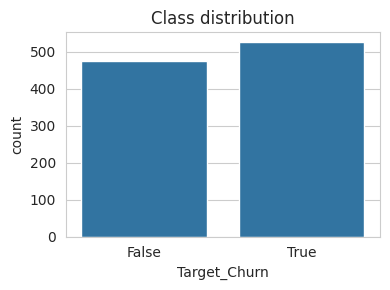

In [6]:
# If your target column is not 'Churn', change it here
TARGET_COL = 'Target_Churn'
assert TARGET_COL in df.columns, f"'{TARGET_COL}' not found in columns! Edit TARGET_COL."

# Plot class distribution
plt.figure(figsize=(4,3))
sns.countplot(x=df[TARGET_COL])
plt.title('Class distribution')
plt.tight_layout()
plt.show()


In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=TARGET_COL)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train size:", X_train.shape, "| Test size:", X_test.shape)


Train size: (800, 14) | Test size: (200, 14)


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

cat_feats = X.select_dtypes(include=['object', 'category']).columns
num_feats = X.select_dtypes(include=['number', 'bool']).columns

numeric_pipe = Pipeline([('imp', SimpleImputer(strategy='median')),
                         ('sc', StandardScaler())])
categorical_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                             ('enc', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, num_feats),
    ('cat', categorical_pipe, cat_feats)
])


In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
smote = SMOTE(random_state=42)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb, lightgbm as lgb, catboost as cb

models = {
    'LogReg': LogisticRegression(max_iter=500, class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(64,32), max_iter=50, random_state=42),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=5, subsample=0.9,
        colsample_bytree=0.9, objective='binary:logistic', eval_metric='auc',
        n_jobs=-1, random_state=42),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=300, learning_rate=0.05, objective='binary', random_state=42),
    'CatBoost': cb.CatBoostClassifier(
        iterations=300, learning_rate=0.05, depth=5, verbose=False, random_seed=42)
}


In [13]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, ConfusionMatrixDisplay)
metrics = defaultdict(list)
full_pipes = {}

for name, clf in models.items():
    pipe = ImbPipeline([
        ('prep', preprocessor),
        ('smote', smote),
        ('model', clf)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:,1]

    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test, preds))
    metrics['Precision'].append(precision_score(y_test, preds, zero_division=0))
    metrics['Recall'].append(recall_score(y_test, preds, zero_division=0))
    metrics['F1'].append(f1_score(y_test, preds, zero_division=0))
    metrics['ROC_AUC'].append(roc_auc_score(y_test, probs))
    full_pipes[name] = pipe
    print(f"{name} completed ✓")

results = pd.DataFrame(metrics).set_index('Model').round(4).sort_values('ROC_AUC', ascending=False)
results


LogReg completed ✓
DecisionTree completed ✓
RandomForest completed ✓
ExtraTrees completed ✓
GradientBoosting completed ✓
SVM completed ✓
KNN completed ✓
NaiveBayes completed ✓


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP completed ✓
XGBoost completed ✓
[LightGBM] [Info] Number of positive: 421, number of negative: 421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 842, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM completed ✓


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CatBoost completed ✓


,Accuracy,Precision,Recall,F1,ROC_AUC
Model,,,,,
DecisionTree,0.590,0.6139,0.5905,0.6019,0.5900
MLP,0.555,0.5755,0.5810,0.5782,0.5669
ExtraTrees,0.505,0.5273,0.5524,0.5395,0.5235
LightGBM,0.495,0.5185,0.5333,0.5258,0.5157
SVM,0.500,0.5238,0.5238,0.5238,0.4991
RandomForest,0.440,0.4679,0.4857,0.4766,0.4796
GradientBoosting,0.495,0.5213,0.4667,0.4925,0.4753
CatBoost,0.470,0.4953,0.5048,0.5000,0.4741
XGBoost,0.485,0.5098,0.4952,0.5024,0.4717


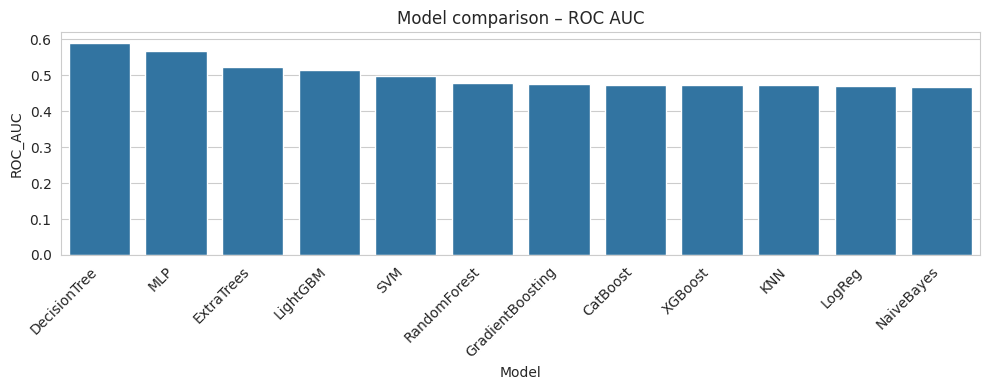

In [14]:
plt.figure(figsize=(10,4))
sns.barplot(x=results.index, y=results['ROC_AUC'])
plt.xticks(rotation=45, ha='right')
plt.title('Model comparison – ROC AUC')
plt.tight_layout()
plt.show()


Best model: DecisionTree


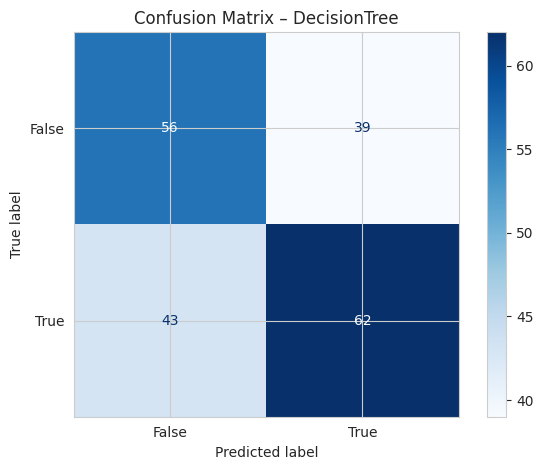

In [15]:
best_model_name = results['ROC_AUC'].idxmax()
best_pipe = full_pipes[best_model_name]
print("Best model:", best_model_name)

best_preds = best_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, best_preds, cmap='Blues')
plt.title(f'Confusion Matrix – {best_model_name}')
plt.tight_layout()
plt.show()


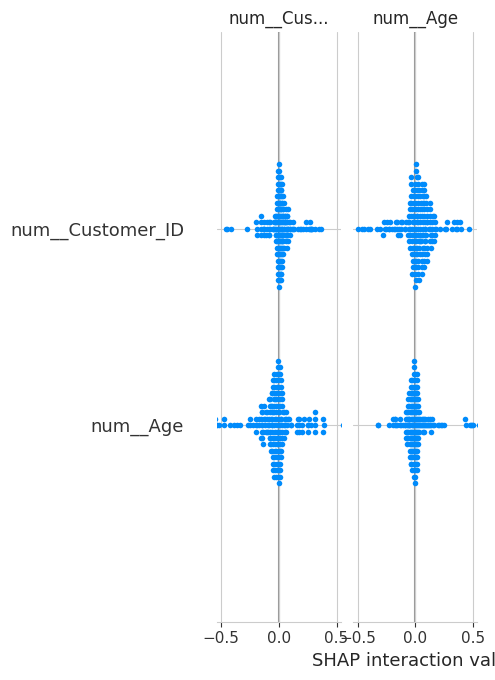

In [16]:
import shap
if hasattr(best_pipe.named_steps['model'], 'feature_importances_'):
    explainer = shap.TreeExplainer(best_pipe.named_steps['model'])
    X_test_transformed = best_pipe.named_steps['prep'].transform(X_test)
    shap_values = explainer.shap_values(X_test_transformed)
    shap.summary_plot(shap_values, feature_names=best_pipe.named_steps['prep'].get_feature_names_out())


In [17]:
import joblib, datetime
fname = f"{best_model_name.lower()}_churn_model.pkl"
joblib.dump(best_pipe, fname)
print("Model saved to", fname)


Model saved to decisiontree_churn_model.pkl
